# DSCI 552 - Final Project

### Name : Ashwin Chafale
### Github username : chafale
### USC-ID : 1990624801

# 1. Text-Classification

## (a) Build a classifier to analyze the sentiment of movies reviews. We are provided with text data in two folders: one folder involves positive reviews, and one folder involves negative reviews.

In [1]:
import glob
import string
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LSTM
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# Load positive sentiments
positive_files = {}
files = glob.glob("../Data/pos/*.txt")
files.sort()
file_count = 0
for file in files:
    f = open(file,'r')
    positive_files[file_count] = ["".join(f.readlines())]
    file_count += 1
df = pd.DataFrame(positive_files, index=[0])
positive_df = df.T
positive_df.rename(columns={0:"reviews"} ,inplace=True)
positive_df

,reviews
0,films adapted from comic books have had plenty...
1,every now and then a movie comes along from a ...
2,you've got mail works alot better than it dese...
3,""" jaws "" is a rare film that grabs your atten..."
4,moviemaking is a lot like being the general ma...
...,...
995,wow ! what a movie . \nit's everything a movie...
996,"richard gere can be a commanding actor , but h..."
997,"glory--starring matthew broderick , denzel was..."
998,steven spielberg's second epic film on world w...


In [3]:
# Load negative sentiments
negative_files = {}
files = glob.glob("../Data/neg/*.txt")
files.sort()
file_count = 0
for file in files:
    f = open(file,'r')
    negative_files[file_count] = ["".join(f.readlines())]
    file_count += 1
df = pd.DataFrame(negative_files, index=[0])
negative_df = df.T
negative_df.rename(columns={0:"reviews"} ,inplace=True)
negative_df

,reviews
0,"plot : two teen couples go to a church party ,..."
1,the happy bastard's quick movie review \ndamn ...
2,it is movies like these that make a jaded movi...
3,""" quest for camelot "" is warner bros . ' firs..."
4,synopsis : a mentally unstable man undergoing ...
...,...
995,"if anything , "" stigmata "" should be taken as ..."
996,"john boorman's "" zardoz "" is a goofy cinematic..."
997,the kids in the hall are an acquired taste . \...
998,there was a time when john carpenter was a gre...


## (b) Data Exploration and Pre-processing

### 1 (b) i. Use binary encoding for the sentiments , i.e y = 1 for positive sentiments and y = − 1 for negative sentiments.

As per the question sentiments have to be [1, -1] but since the output layer of Neural Network is sigmoid we will assume
sentiments to be [1, 0] where 1 represent positive review and 0 represent negative review respectively.

The above assumption is for assignment simplicity.

In [4]:
positive_df['sentiments'] = [1] * len(positive_df)
negative_df['sentiments'] = [0] * len(negative_df) # make it -1

### 1 (b) ii. Remove the punctuation and numbers from the data.

Here in data preprocessing step english "stopword" are not been removed as I have observed that when stopwords are not removed our NN model accuracy increases.

This behaviour is due to "not", "much" ... etc are considered stopword in nltk.corpus and few such stopwords might be useful for our model.

So I am not eliminating english stopwords.


In [5]:
# from nltk.corpus import stopwords
def generateTokens(dataFrame):
    token_list = []
    for fileData in dataFrame['reviews']:

        # split into tokens by white space
        _tokens = fileData.split()

        # remove punctuation from each token
        table = str.maketrans('', '', string.punctuation)
        _tokens = [w.translate(table) for w in _tokens]

        # remove remaining tokens that are not alphabetic
        _tokens = [word for word in _tokens if word.isalpha()]

        # # filter out stop words
        # stop_words = set(stopwords.words('english'))
        # _tokens = [w for w in _tokens if not w in stop_words]

        # filter out short tokens
        _tokens = [word for word in _tokens if len(word) > 2]

        token_list.append(_tokens)

    return token_list

In [6]:
def dataPreprocessing(dataFrame):
    cleaned_data_list = []

    for fileData in dataFrame['tokens']:
        cleaned_data = " ".join(fileData)
        cleaned_data_list.append(cleaned_data)

    return cleaned_data_list

In [7]:
positive_df['sentiments'] = [1] * len(positive_df)
negative_df['sentiments'] = [0] * len(negative_df) # make it -1

### 1 (b) iii. Use text files 0-699 in each class for training and 700-999 for testing.

In [8]:
positive_train, negative_train = positive_df[:700], negative_df[:700]
positive_test, negative_test = positive_df[700:], negative_df[700:]

In [9]:
p_list = generateTokens(positive_df)
n_list = generateTokens(negative_df)
p_train, n_train = p_list[:700], n_list[:700]
p_test, n_test = p_list[700:], n_list[700:]

In [10]:
X_train = p_train + n_train
X_test = p_test + n_test
y_train = pd.concat([positive_train.iloc[:,1], negative_train.iloc[:,1]], ignore_index=True)
y_test = pd.concat([positive_test.iloc[:,1], negative_test.iloc[:,1]], ignore_index=True)

### 1 (b) iv. Count the number of unique words in the whole dataset (train + test) and print it out.

In [11]:
from collections import Counter

completeDataset = p_list + n_list

uniqueWords = Counter()
for strList in completeDataset:
    uniqueWords.update(strList)
uniqueWords

Counter({'films': 2102,
         'adapted': 45,
         'from': 4986,
         'comic': 375,
         'books': 81,
         'have': 4899,
         'had': 1544,
         'plenty': 129,
         'success': 216,
         'whether': 216,
         'theyre': 414,
         'about': 3518,
         'superheroes': 12,
         'batman': 195,
         'superman': 23,
         'spawn': 75,
         'geared': 13,
         'toward': 100,
         'kids': 339,
         'casper': 22,
         'the': 76324,
         'arthouse': 7,
         'crowd': 74,
         'ghost': 74,
         'world': 963,
         'but': 8584,
         'theres': 993,
         'never': 1364,
         'really': 1563,
         'been': 2045,
         'book': 330,
         'like': 3553,
         'hell': 261,
         'before': 987,
         'for': 9914,
         'starters': 8,
         'was': 4934,
         'created': 162,
         'alan': 99,
         'moore': 73,
         'and': 35351,
         'eddie': 143,
         'campbell': 

In [12]:
len(uniqueWords)

46473

### 1 (b) v. Calculate the average review length and the standard deviation of review lengths. Report the results.

In [13]:
# Summarize review length
X = p_list + n_list
print("Review length summary : ")
result = [len(x) for x in X]
print("Average review length = ", np.mean(result))
print("Standard deviation of review length = ", np.std(result))
print("Maximum review length", np.max(result))

Review length summary : 
Average review length =  518.621
Standard deviation of review length =  228.57963242380106
Maximum review length 1875


### 1 (b) vi. Plot the histogram of review lengths.

[]

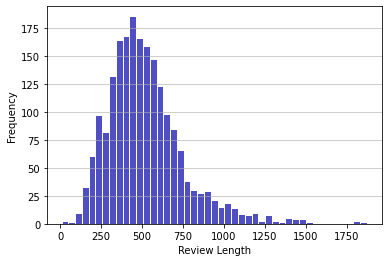

In [14]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=result, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.plot()

### 1 (b) viii. Select a review length L that 70% of the reviews have a length below it.

From the review length summary and histogram, we will choose L = 750 which corresponds to 70% of the reviews that have a length below it.

In [15]:
L = 750

### 1 (b) vii. Tokenization
The most common word in the text will be represented as 1, the second most common word will be represented as 2, etc. We will tokenize each text document using this method.

In [16]:
# create the tokenizer
tokenizer = Tokenizer()

# fit the tokenizer on the documents
tokenizer.fit_on_texts(X_train)

### 1 (b) ix. Truncate reviews longer than L words and zero-pad reviews shorter than L so that all texts are of length L

In [17]:
# sequence encode
encoded_docs = tokenizer.texts_to_sequences(X_train)

# pad sequences
max_length = L # from section 1 (b) vii
print(max_length)

Xtrain = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
Xtrain

750


array([[   46,  3370,    17, ...,     0,     0,     0],
       [  123,   115,     2, ...,     0,     0,     0],
       [  682,   260,  4108, ...,     0,     0,     0],
       ...,
       [ 5796,   630,   570, ...,     0,     0,     0],
       [   62,  1657, 22628, ...,     0,     0,     0],
       [ 1062,    33,    96, ...,     0,     0,     0]], dtype=int32)

In [18]:
# sequence encode
encoded_docs = tokenizer.texts_to_sequences(X_test)

# pad sequences
Xtest = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
Xtest

array([[  472,   251, 11299, ...,  1421,  1022,   549],
       [  631, 10182,   928, ...,    35,   938,  1847],
       [    1,    53,  6680, ...,     0,     0,     0],
       ...,
       [    1,   363,     1, ...,     0,     0,     0],
       [   34,    16,    42, ...,     0,     0,     0],
       [   59,   841,   431, ...,     0,     0,     0]], dtype=int32)

## 1 (c) Word Embeddings

### 1 (c) i. Tokenized the input text using "Word Embedding"

In [19]:
# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

39290

In [20]:
embedding_layer = Embedding(vocab_size, 32, input_length=max_length)

### 1 (c) ii. Flatten the matrix of each document to a vector

We can achieve this by using `keras.layers.Flatten`.
Flattening of matrix is done in below code. Please refer 1 (d), 1(e), 1(f).



## 1 (d) Multi-Layer Perceptron

##### 1 (d) i. Train a MLP with three (dense) hidden layers each of which has 50 ReLUs and one output layer with a single sigmoid neuron. Use a dropout rate of 20% for the first layer and 50% for the other layers. Use ADAM optimizer and binary cross entropy loss (which is equivalent to having a softmax in the output). To avoid overfitting, just set the number of epochs as 2. Use a batch size of 10.

In [21]:
from keras.layers import Dropout
model = Sequential()
model.add(Embedding(vocab_size, 32, input_length=max_length))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 750, 32)           1257280   
_________________________________________________________________
flatten_1 (Flatten)          (None, 24000)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1200050   
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)               

### 1 (d) ii. Report the train and test accuracies of this model.

In [22]:
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(Xtrain, y_train, batch_size= 10, epochs=2)


Epoch 1/2
140/140 [==============================] - 3s 17ms/step - loss: 0.6688 - accuracy: 0.5914
Epoch 2/2
140/140 [==============================] - 2s 18ms/step - loss: 0.4681 - accuracy: 0.7814



In [26]:
# evaluate
_, acc = model.evaluate(Xtest, y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 60.333333


#### Observation :
If we increase the number of epoch the test accuracy increases.
Here in below code we will run MLP for 10 epoch.


In [24]:
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(Xtrain, y_train, batch_size= 10 ,epochs=10)

Epoch 1/10
1400/1400 [==============================] - 6s 4ms/step - loss: 0.6978 - accuracy: 0.4971
Epoch 2/10
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6882 - accuracy: 0.5550
Epoch 3/10
1400/1400 [==============================] - 5s 4ms/step - loss: 0.6144 - accuracy: 0.6793
Epoch 4/10
1400/1400 [==============================] - 5s 4ms/step - loss: 0.2993 - accuracy: 0.8836
Epoch 5/10
1400/1400 [==============================] - 5s 4ms/step - loss: 0.0617 - accuracy: 0.9800
Epoch 6/10
1400/1400 [==============================] - 5s 4ms/step - loss: 0.0327 - accuracy: 0.9907
Epoch 7/10
1400/1400 [==============================] - 6s 4ms/step - loss: 0.0185 - accuracy: 0.9950
Epoch 8/10
1400/1400 [==============================] - 5s 4ms/step - loss: 0.0135 - accuracy: 0.9971
Epoch 9/10
1400/1400 [==============================] - 5s 4ms/step - loss: 0.0125 - accuracy: 0.9943
Epoch 10/10
1400/1400 [==============================] - 5s 4ms/step - loss: 0.006

In [25]:
# evaluate
_, acc = model.evaluate(Xtest, y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 66.666669


## 1 (e) One-Dimensional Convolutional Neural Network:

###### 1 (e) i. After the embedding layer, insert a Conv1D layer. This convolutional layer has 32 feature maps , and each of the 32 kernels has size 3, i.e. reads embedded word representations 3 vector elements of the word embedding at a time. The convolutional layer is followed by a 1D max pooling layer with a length and stride of 2 that halves the size of the feature maps from the convolutional layer. The rest of the network is the same as the neural network above.

In [27]:
model = Sequential()
model.add(Embedding(vocab_size, 32, input_length=max_length))
model.add(Conv1D(filters=32, kernel_size=32))
model.add(MaxPooling1D(strides=2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 750, 32)           1257280   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 719, 32)           32800     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 359, 32)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 11488)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 11488)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                574450    
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)               

### 1 (e) ii. Report the train and test accuracies of this model.

In [28]:
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(Xtrain, y_train, batch_size= 10 ,epochs=2)


Epoch 1/2
140/140 [==============================] - 6s 37ms/step - loss: 0.6341 - accuracy: 0.6407
Epoch 2/2
140/140 [==============================] - 5s 38ms/step - loss: 0.3357 - accuracy: 0.8714



In [29]:
# evaluate
_, acc = model.evaluate(Xtest, y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 80.833334


#### Observation :
If we increase the number of epoch the test accuracy increases.
Here in below code we will run 1D-CNN for 10 epoch.

In [30]:
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(Xtrain, y_train, batch_size= 10 ,epochs=10)

Epoch 1/10
1400/1400 [==============================] - 13s 9ms/step - loss: 0.7001 - accuracy: 0.5243
Epoch 2/10
1400/1400 [==============================] - 12s 9ms/step - loss: 0.6911 - accuracy: 0.5379
Epoch 3/10
1400/1400 [==============================] - 12s 9ms/step - loss: 0.6855 - accuracy: 0.5814
Epoch 4/10
1400/1400 [==============================] - 12s 9ms/step - loss: 0.4559 - accuracy: 0.8050
Epoch 5/10
1400/1400 [==============================] - 12s 9ms/step - loss: 0.1754 - accuracy: 0.9479
Epoch 6/10
1400/1400 [==============================] - 15s 11ms/step - loss: 0.0487 - accuracy: 0.9886
Epoch 7/10
1400/1400 [==============================] - 13s 9ms/step - loss: 0.0163 - accuracy: 0.9929
Epoch 8/10
1400/1400 [==============================] - 12s 9ms/step - loss: 0.0194 - accuracy: 0.9950
Epoch 9/10
1400/1400 [==============================] - 12s 9ms/step - loss: 0.0067 - accuracy: 0.9979
Epoch 10/10
1400/1400 [==============================] - 12s 9ms/step - 

In [31]:
# evaluate
_, acc = model.evaluate(Xtest, y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 83.833331


## 1 (f) Long Short-Term Memory Recurrent Neural Network:

###### 1 (f) i. Each word is represented to LSTM as a vector of 32 elements and the LSTM is followed by a dense layer of 256 ReLUs. Use a dropout rate of 0.2 for both LSTM and the dense layer. Train the model using 10-50 epochs and batch size of 10.

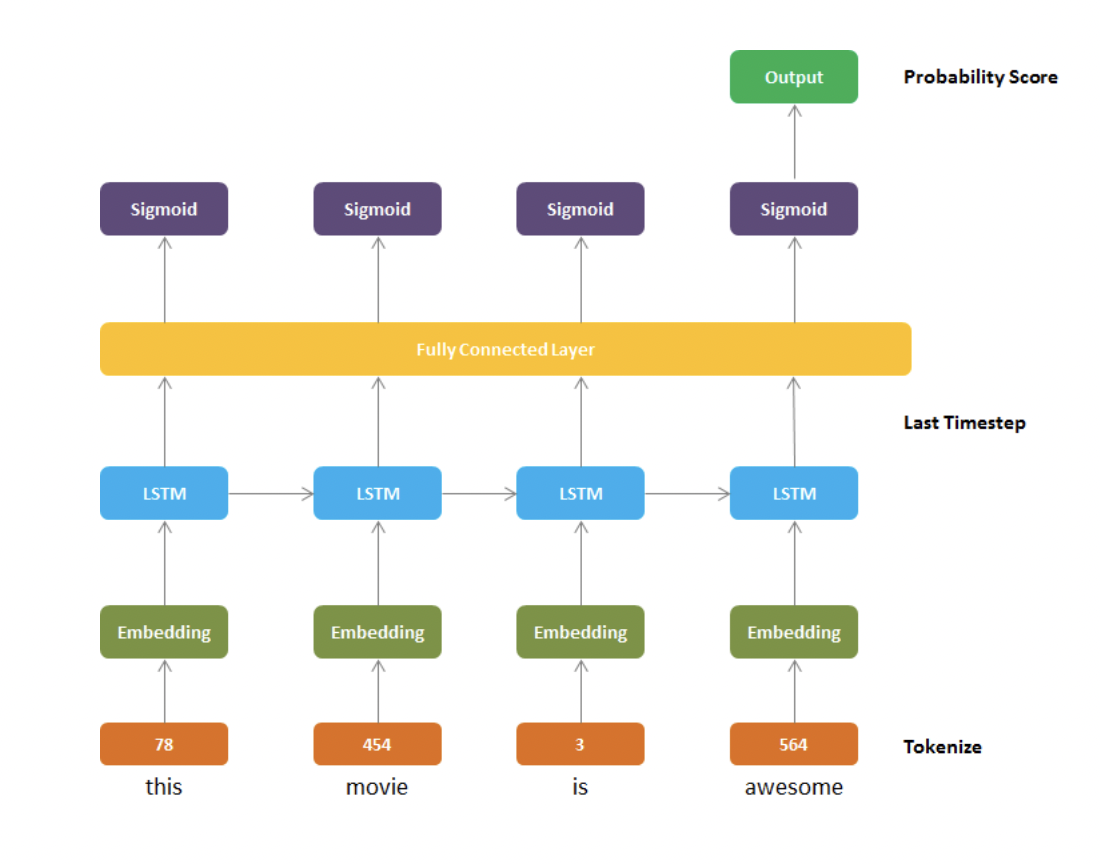

In [32]:
from IPython.display import Image
Image(filename="img.png")

In [33]:
model = Sequential()
model.add(Embedding(vocab_size, 32, input_length=max_length))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 750, 32)           1257280   
_________________________________________________________________
dropout_9 (Dropout)          (None, 750, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               8448      
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                

### 1 (f) ii. Report the train and test accuracies of this model.

In [34]:
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(Xtrain, y_train, batch_size= 10 ,epochs=50)


Epoch 1/50
140/140 [==============================] - 51s 349ms/step - loss: 0.6934 - accuracy: 0.5179
Epoch 2/50
140/140 [==============================] - 49s 347ms/step - loss: 0.6818 - accuracy: 0.5443
Epoch 3/50
140/140 [==============================] - 48s 346ms/step - loss: 0.6622 - accuracy: 0.5657
Epoch 4/50
140/140 [==============================] - 48s 346ms/step - loss: 0.6331 - accuracy: 0.5871
Epoch 5/50
140/140 [==============================] - 48s 346ms/step - loss: 0.7908 - accuracy: 0.5350
Epoch 6/50
140/140 [==============================] - 48s 346ms/step - loss: 0.6637 - accuracy: 0.5493
Epoch 7/50
140/140 [==============================] - 48s 346ms/step - loss: 0.6581 - accuracy: 0.5507
Epoch 8/50
140/140 [==============================] - 49s 348ms/step - loss: 0.6331 - accuracy: 0.6129
Epoch 9/50
140/140 [==============================] - 48s 346ms/step - loss: 0.5840 - accuracy: 0.7064
Epoch 10/50
140/140 [==============================] - 38s 270ms/step - 

In [37]:
# evaluate
_, acc = model.evaluate(Xtest, y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 67.500002


## References :-
- <https://datagy.io/python-remove-punctuation-from-string/>
- <https://stackoverflow.com/questions/12851791/removing-numbers-from-string>
- <https://stackoverflow.com/questions/18936957/count-distinct-words-from-a-pandas-data-frame>
- <https://towardsdatascience.com/pandas-concat-tricks-you-should-know-to-speed-up-your-data-analysis-cd3d4fdfe6dd#:~:text=If%20you%20want%20the%20concatenation,%2C%20%E2%80%A6%2C%20n%2D1%20.&text=To%20concatenate%20DataFrames%20horizontally%20along,set%20the%20argument%20axis%3D1%20.>
- <https://machinelearningmastery.com/predict-sentiment-movie-reviews-using-deep-learning/>
- <https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/>
- <https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/>
- <https://github.com/darshanbagul/LSTM_Sentiment_Classification/blob/master/IMDB_Sentiment_Classification_LSTM.ipynb>
- <https://keras.io/api/datasets/imdb/>
- <https://www.kaggle.com/code/faressayah/nlp-sentiment-analysis-with-keras/notebook>
- <https://medium.com/geekculture/sentiment-analysis-using-rnn-keras-e545fbe000>
- <https://www.linkedin.com/learning/building-recommender-systems-with-machine-learning-and-ai/sentiment-analysis-of-movie-reviews-using-rnns-and-keras?autoplay=true&u=76870426>
- <https://machinelearningknowledge.ai/keras-tokenizer-tutorial-with-examples-for-fit_on_texts-texts_to_sequences-texts_to_matrix-sequences_to_matrix/>
- <https://stackabuse.com/python-for-nlp-word-embeddings-for-deep-learning-in-keras/>